# Modeling

# Inhouds opgaven modeling

## 1. Libraries
## 2. Data Inladen
## 3. Data retrieve
## 4. Baseline model
## 5. Lineaire regression
## 6. Random forest  regression


# 1. Libraries

Hier importeren we de benodigde libraries voor de modellen.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import r2_score
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# 2. Data Inladen

Hier onder wordt de data in geladen van uit het data preperation.

In [24]:
%%capture
%run 3.Data_Preparation.ipynb

In [25]:
prep_list = return_model_data()
table = prep_list[0]
table.head(3)

,#stm_sap_meldnr,stm_sap_meld_ddt,stm_geo_mld,stm_geo_mld_uit_functiepl,stm_equipm_nr_mld,stm_equipm_soort_mld,stm_km_van_mld,stm_km_tot_mld,stm_prioriteit,stm_status_melding_sap,...,stm_techn_gst,stm_progfh_in_duur,stm_progfh_gw_teller,stm_fh_duur,stm_reactie_duur,stm_meld_gebeld_duur,stm_meld_ter_plekken_duur,stm_gebeld_ter_plekken_duur,stm_equipm_soort_mld_looe_mean,stm_techn_mld_looe_mean
32099,50112759,2012-06-12 20:50:00,104.0,104.0,None,None,0.0,0.0,9.0,MAFS,...,X,40.0,0.0,43.0,3.0,492.0,495.0,3.0,137.836737,138.925088
52801,50126248,2014-02-23 07:00:00,38.0,38.0,None,None,0.0,0.0,9.0,MAFS TVTK,...,X,0.0,0.0,15.0,0.0,0.0,0.0,0.0,116.550418,140.061987
55827,50127448,2014-04-21 03:37:00,NaN,NaN,None,None,0.0,0.0,9.0,MAFS TVTK,...,X,0.0,0.0,11.0,0.0,1523.0,0.0,0.0,134.207690,131.495417


# 3. Data retrieval

Voor het terug halen van de modellen voor de evaluatie is hier een functie die de benodigde modellen retourneert.

In [26]:
def return_models():
    liniar_reg
    return [liniar_reg, random_forest, prep_list[1]]
# preplist is target encoder

# 4. Baseline model

Hier gebruiken we een dummy regressor voor een baseline model. We gebruiken hier voor de optie mean dit geeft altijd de gemiddelde tijd duur als voorspelling terug. 

In [46]:
#DummyRegressor
X_train, X_test, Y_train, Y_test = train_test_split(table['stm_fh_duur'], table['stm_fh_duur'])

# We nemen de mean om alle data mee te nemen en ook de uitschieters.
BaselineDummyRegressor = DummyRegressor(strategy="mean")
BaselineDummyRegressor.fit(X_train, Y_train)

y_pred = BaselineDummyRegressor.predict(X_test)
accuracy_r2 = BaselineDummyRegressor.score(Y_test, y_pred)

print("Echte waarde: ", Y_test[0:1].values[0])
print("Voorspelde waarde: ", y_pred[0:1][0])
print("RSME: ", np.sqrt(mean_squared_error(y_pred, Y_test)))

Echte waarde:  42.0
Voorspelde waarde:  134.53502384327876
RSME:  121.69928704418686


We kunnen hieruit concluderen dat als altijd de gemiddelde duur wordt gegeven als predictie dat de fout afstand 121 minuten is. Dus onze modellen zouden dus onder deze afstand in tijd moeten komen willen ze functioneel zijn.

<AxesSubplot:xlabel='stm_fh_duur'>

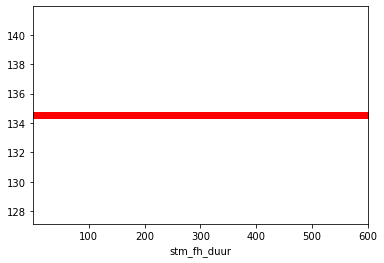

In [47]:
# Prediction tegen eigenlijke uitkomst
sns.regplot(x=Y_test, y=y_pred, ci=None, color="r")

# 5 Lineaire regression

We hebben hier gebruik gemaakt van lineaire regressie. Hier hebben we gebruik gemaakt van de prognose duur, duur ter plekken en equipment soort encoded.

In [29]:
linreg_table = table[['stm_progfh_in_duur','stm_equipm_soort_mld_looe_mean', 'stm_gebeld_ter_plekken_duur']]
X_train, X_test, Y_train, Y_test = train_test_split(linreg_table, table['stm_fh_duur'])

Er is te zien dat de rsme van de hele data set 64 is. Er is dus een verbetering van de tijds gebaseerd op het gemiddelde.

In [30]:
liniar_reg = LinearRegression()

liniar_reg.fit(X_train,Y_train)

y_pred = liniar_reg.predict(X_test)

accuracy_r2 = r2_score(Y_test, y_pred) 

print("Echte waarde: ", Y_test[0:1].values[0])
print("Voorspelde waarde: ", y_pred[0:1][0])
print("R2: ",  accuracy_r2)
print("RSME: ", np.sqrt(mean_squared_error(y_pred, Y_test)))

Echte waarde:  17.0
Voorspelde waarde:  60.36367947467208
R2:  0.7221291118703006
RSME:  64.00194276360182


Hier is de visualisatie van de regressielijn op de y as is de predictie tijd te zien en op de x de functie hersteltijd. Er is hier uit te zien dat de predicties beter lopen in vergelijking tot het gemiddelde. Er is ook een lichtelijke op gaande lijn te herken in de grafiek alleen is het model ver van goed met een rsme van 64

<AxesSubplot:xlabel='stm_fh_duur'>

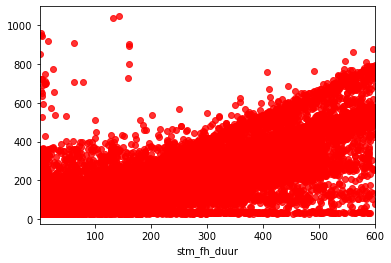

In [31]:
# Prediction tegen eigenlijke uitkomst
sns.regplot(x=Y_test, y=y_pred, ci=None, color="r")

# 6. Random forest  regression

We zijn overgegaan naar een random forest regression model om te kijken of er verbeteringen waren te maken met de uitkomsten. Er wordt hier onder in een lange loop gekeken wat de beste random forest tree zou zijn er wordt gekeken naar verschillende hyperparameters: leaf, split, tree amount en depth gezocht welke combinatie de laagste rsme score heeft.

In [32]:
def find_best_tree(table):
    x_coloms = table[['stm_equipm_soort_mld_looe_mean', 'stm_progfh_in_duur', 'stm_gebeld_ter_plekken_duur']].astype('int64').values
    y_coloms = table['stm_fh_duur'].astype('int64').values

    max_depth = 20
    range_depths = range(max_depth)
    min_leaf = [3, 5, 11, 16, 20]
    min_split = [3,10,15,20]
    n_range = [1,2,3,4,5]

    acc_list = []
    meanscore = 999
    meanscore_label = ""
    best_regessors = []
    for n in n_range:
        for dept in range_depths[1:]:
            for leaf in min_leaf:
                for split in min_split:
                    x_train, x_test, y_train, y_test = train_test_split(x_coloms, y_coloms)
                    random_forest = RandomForestRegressor(n_estimators=n, criterion='mse', max_depth=dept, min_samples_leaf = leaf, min_samples_split = split, n_jobs=-2)
                    random_forest.fit(x_train, y_train)
                    y_pred = random_forest.predict(x_test)

                    mean = np.sqrt(mean_squared_error(y_test, y_pred))
                    if mean < meanscore:
                        meanscore = mean  
                        best_regessors = [random_forest]
                        meanscore_label = ("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)), "R2: ", r2_score(y_test, y_pred), "Tree: ", n, "Depth: ", dept, "Leaf: ", leaf, "Split", split)
       
        print('Complete one', remember)
        remember = remember+1
    print(meanscore_label)
    
# Uncommended voor evaluation import. Duurt te lang
# find_best_tree(table)

Complete one 1
Complete one 2
Complete one 3
Complete one 4
Complete one 5
('RMSE: ', 55.42396866232407, 'R2: ', 0.7912907837761122, 'Tree: ', 5, 'Depth: ', 10, 'Leaf: ', 11, 'Split', 3)


Hier onder tonen we de uit komst van het model met de beste hyperparameters. We zien daar bij de predictie, prognose en echte tijdsduur van de storing.

In [49]:
x_coloms = table[['stm_equipm_soort_mld_looe_mean', 'stm_progfh_in_duur', 'stm_gebeld_ter_plekken_duur', 'stm_techn_mld_looe_mean',]].astype('int64')
y_coloms = table['stm_fh_duur'].astype('int64').values

x_train, x_test, y_train, y_test = train_test_split(x_coloms, y_coloms)
random_forest = RandomForestRegressor(n_estimators=5, min_samples_leaf = 11, max_depth=10,  min_samples_split = 3, n_jobs=-2)
random_forest.fit(x_train, y_train)
y_pred = random_forest.predict(x_test)

accuracy_r2 = r2_score(y_test, y_pred)

print("Echte waarde: ", Y_test[0:1].values[0])
print("Voorspelde waarde: ", y_pred[0:1][0])
print("Prognose waarde: ", x_coloms['stm_progfh_in_duur'].iloc[0])
print("R2: ",  accuracy_r2)
print("RSME: ", np.sqrt(mean_squared_error(y_pred, y_test)))

Echte waarde:  42.0
Voorspelde waarde:  98.12599461732555
Prognose waarde:  40
R2:  0.7897223865355122
RSME:  55.827301588445856


Er is een betere rsme van 56 te zien. In de uitkomst hierboven is er te zien dat de voorspelling ver van de echte waarde ligt in vergelijking tot de prognose. Er dit was helaas al te verwachten met een rsme van 56.

Hier onder bekijken hoe veel waarde de verschillende kolommen bijdragen aan het maken van de random forest prediction. Er is hier uit te zien dat de grootse importance de terplekken duur is. Dit was te verwachten in na het onderzoek in data understanding omdat ter plekke duur een lichtelijk linair verband heeft met de totalen functie herstel tijd duur.

Text(0.5, 1.0, 'Importance random forest')

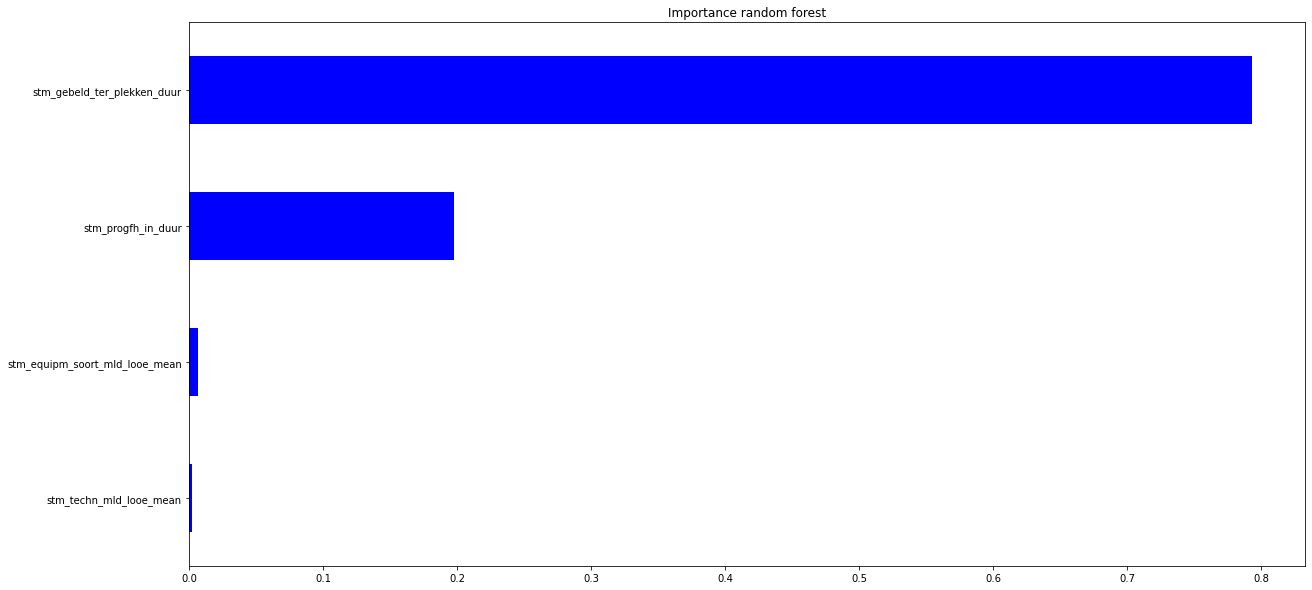

In [34]:
importence = random_forest.feature_importances_
grapfh = pd.Series(importence, x_coloms.columns)
fig, (ax1) = plt.subplots(1,1, figsize=(20,10))
grapfh.sort_values().plot.barh(color='blue')
plt.title('Importance random forest')

We nemen hieronder nog een kijkje naar wat voor rsme eruit komt zonder de ter plekken duur. Om een betere kijk te krijgen in de importance van de andere 2 kolommen

In [51]:
x_coloms = table[['stm_equipm_soort_mld_looe_mean', 'stm_progfh_in_duur', 'stm_techn_mld_looe_mean']].astype('int64')
y_coloms = table['stm_fh_duur'].astype('int64').values

x_train, x_test, y_train, y_test = train_test_split(x_coloms, y_coloms)
random_forest = RandomForestRegressor(n_estimators=5, min_samples_leaf = 11, max_depth=10,  min_samples_split = 3, n_jobs=-2)
random_forest.fit(x_train, y_train)
y_pred = random_forest.predict(x_test)

accuracy_r2 = r2_score(y_test, y_pred)

print("Echte waarde: ", Y_test[0:1].values[0])
print("Voorspelde waarde: ", y_pred[0:1][0])
print("Prognose waarde: ", x_coloms['stm_progfh_in_duur'].iloc[0])
print("R2: ",  accuracy_r2)
print("RSME: ", np.sqrt(mean_squared_error(y_pred, y_test)))

Echte waarde:  42.0
Voorspelde waarde:  134.19015277068252
Prognose waarde:  40
R2:  0.2466318196561863
RSME:  105.64866463502871


Met een rsme van 105 komen we erg dicht bij de gemiddelde rsme. Daar naast is er te zien dat de kolommen van equipment soort en technische bijdragen erg klein is in vergelijking tot de orinelen prognose

Text(0.5, 1.0, 'Importance random forest')

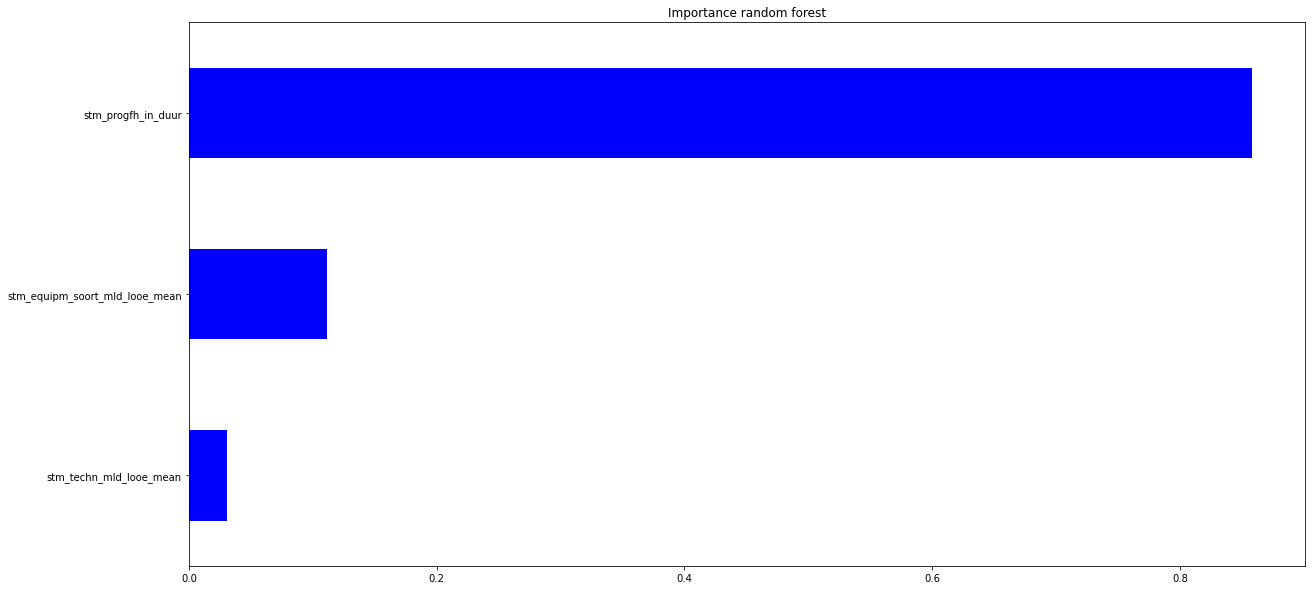

In [36]:
importence = random_forest.feature_importances_
grapfh = pd.Series(importence, x_coloms.columns)
fig, (ax1) = plt.subplots(1,1, figsize=(20,10))
grapfh.sort_values().plot.barh(color='blue')
plt.title('Importance random forest')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=df0a20df-15ef-4481-b361-742b03a94b10' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>